<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    Mini-Challenge 2:<br>Paper-Studium und Umsetzung
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Gabriel Torres Gamez im FS 2023.
</p>

## Ziel
Vertiefung in ein eher aktuelles Paper aus der Forschung und Umsetzung eines darin <br>
beschriebenen oder verwandten Tasks - gemäss Vereinbarung mit dem Fachcoach.  

Beispiel: Implementiere, trainiere und validiere ein Deep Learning Modell für Image <br>
Captioning wie beschrieben im Paper Show and Tell.

## Setup
Hier wird vor der Bearbeitung alles aufgesetzt.

In [1]:
# Install requirements
print("Installing requirements...")
%cd MC2
%pip install --upgrade pip -q
%pip install --upgrade -r requirements.txt -q
print("Done installing requirements!\n")

# Standard Libraries
import logging
import warnings

# 3rd Party Libraries
import dvclive
import gensim
import matplotlib as mpl
import nltk
import numpy as np
import pytorch_lightning as li
import sys
import torch
import torchvision
import tqdm as tqdm_module
import wandb


## Specific Imports
from argparse import Namespace
from dvclive.lightning import DVCLiveLogger
from gensim.models import Word2Vec
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize as nltk_word_tokenize
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from tqdm import tqdm


# Print information about the environment
print("Packages: ")
print(f" | Python Version: {sys.version}")
#print(f" | Dvclive Version: {dvclive.__version__}")
print(f" | Gensim Version: {gensim.__version__}")
print(f" | Matplotlib Version: {mpl.__version__}")
print(f" | NLTK Version: {nltk.__version__}")
print(f" | Numpy Version: {np.__version__}")
print(f" | PyTorch Lightning Version: {li.__version__}")
print(f" | PyTorch Version: {torch.__version__}")
print(f" | Torchvision Version: {torchvision.__version__}")
print(f" | tqdm Version: {tqdm_module.__version__}")
print(f" | Wandb Version: {wandb.__version__}")
print()

print("Backends: ")
print(f" | CUDA: {torch.cuda.is_available()}")
print(f"  | CUDA Built: {torch.backends.cuda.is_built()}")
print(f" | MPS: {torch.backends.mps.is_available()}")
print(f"  | MPS Built: {torch.backends.mps.is_built()}")
print()

print("Ressources: ")
print(f" | CPU Threads: {torch.get_num_threads()}")
for i in range(torch.cuda.device_count()):
    print(f" | GPU {i+1}: {torch.cuda.get_device_name(i)}\n")

# Set torch settings
if torch.cuda.is_available():  # explicitly use NVIDIA GPU's
    accelerator = "cuda"
elif torch.backends.mps.is_available():  # use APPLE Metal
    accelerator = "mps"
else:  # CPU
    accelerator = "cpu"
torch.set_float32_matmul_precision("medium")

# silent warnings
%env WANDB_SILENT=True
warnings.filterwarnings("ignore")
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

# download the nltk tokenizer
nltk.download("punkt", quiet=True)

# Final message
print("Setup complete!\n")

Installing requirements...
[Errno 2] No such file or directory: 'MC2'
/Users/gabriel.torres/Nextcloud/Development/Current/deep-learning/deep-learning/Projects/DEL-MC2
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Done installing requirements!

Packages: 
 | Python Version: 3.10.11 (main, Apr  7 2023, 07:24:53) [Clang 14.0.0 (clang-1400.0.29.202)]
 | Gensim Version: 4.3.1
 | Matplotlib Version: 3.7.1
 | NLTK Version: 3.8.1
 | Numpy Version: 1.24.3
 | PyTorch Lightning Version: 2.0.2
 | PyTorch Version: 2.0.1
 | Torchvision Version: 0.15.2
 | tqdm Version: 4.65.0
 | Wandb Version: 0.15.3

Backends: 
 | CUDA: False
  | CUDA Built: False
 | MPS: True
  | MPS Built: True

Ressources: 
 | CPU Threads: 8
env: WANDB_SILENT=True
Setup complete!



#### Hyperparameters

In [2]:
wordvector_size = 256
t2v_epochs = 50
num_workers = 8
batch_size = 64

# NIC
epochs_train = 10
hidden_size_lstm = 256
learning_rate = 0.1

## Arbeitsschritte

### Schritt 1: Daten 
Gemäss Vereinbarung (für Captioning: Flickr8k-Daten). 

Absprache/Beschluss mit Coach und Beschluss, was evaluiert werden soll. 

In [3]:
def word_tokenize(text):
    return ["<start>"] + nltk_word_tokenize(text) + ["<end>"]


def load_captions(ann_file, tokenizer):
    anns = open(ann_file, "r", encoding="utf-8").read().split("\n")

    # tokenize captions
    captions = {}
    for line in anns:
        if len(line):
            file, caption = line.split(";")
            if file not in captions:
                captions[file] = [tokenizer(caption.lower())]
            else:
                captions[file].append(tokenizer(caption.lower()))

    # pad captions
    max_len = max(len(caption) for file in captions for caption in captions[file])
    for file in captions:
        for caption in captions[file]:
            caption += ["<pad>"] * (max_len - len(caption))

    return captions


def load_images(root, captions):
    images = {}
    for file in tqdm(captions, desc="Loading images"):
        image = Image.open(f"{root}/{file}").convert("RGB")
        transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ]
        )
        image = transform(image)
        images[file] = image

    return images

In [4]:
root = "data/images"
ann_file = "data/captions.txt"

captions_dict = load_captions(ann_file, word_tokenize)
images_dict = load_images(root, captions_dict)

Loading images: 100%|██████████| 8091/8091 [00:30<00:00, 264.21it/s]


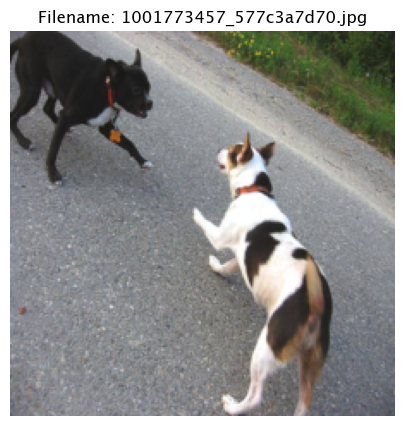

Captions:
 | ['<start>', 'a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
 | ['<start>', 'a', 'black', 'dog', 'and', 'a', 'tri-colored', 'dog', 'playing', 'with', 'each', 'other', 'on', 'the', 'road', '.', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
 | ['<start>', 'a', 'black', 'dog', 'and', 'a', 'white', 'dog', 'with', 'brown', 'spots', 'are', 'staring', 'at', 'each', 'other', 'in', 'the', 'street', '.', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<

In [5]:
# get a random picture and its captions
file, caption = list(captions_dict.items())[1]
image = images_dict[file]

plt.figure(figsize=(5, 5))
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Filename: {file}")
plt.axis("off")
plt.show()

print("Captions:")
for caption in caption:
    print(f" | {caption}")

#### Encoding the images

In [6]:
# Encoding via EfficientNetB0
def get_model_efficientnetb0():
    # Load the model
    model = torchvision.models.efficientnet_b0(pretrained=True)
    model.eval()
    model.requires_grad_(False)

    # Transfer the model to the appropriate device
    model.to(accelerator)

    # Remove the last layer
    model._fc = torch.nn.Identity()

    return model


def encode_images(images, model, batch_size=batch_size):
    # Dictionary to store the encoded images
    encoded_images = {}

    with torch.no_grad():
        # Iterate over the images in batches
        for i in tqdm(
            range(0, len(images), batch_size),
            desc=f"Encoding images in batches of {batch_size}",
        ):
            # Get the file names for the current batch
            batch_files = list(images.keys())[i : i + batch_size]
            # Get the images for the current batch and move them to the appropriate device
            batch_images = torch.stack(list(images.values())[i : i + batch_size]).to(
                accelerator
            )
            # Encode the images in the batch and move them to the CPU
            encoded_batch = model(batch_images).cpu()

            # Store the encoded images in the dictionary
            for j, file in enumerate(batch_files):
                encoded_images[file] = encoded_batch[j]

    return encoded_images

In [7]:
efficientnetb0 = get_model_efficientnetb0()
encoded_images = encode_images(images_dict, efficientnetb0, batch_size)

Encoding images in batches of 64: 100%|██████████| 127/127 [00:18<00:00,  7.04it/s]


#### Encoding the captions
The Word2Vec model is trained before the Train, Validation and Test Split because we want to use the same word embedding for all the splits. 

This could falsify the results because the model could learn words that are in the validation and test set.

In [8]:
def word_to_vec(captions):
    # All captions as a vector
    captions_vector = [
        image for captions in captions_dict.values() for image in captions
    ]

    # Create the model
    model = Word2Vec(
        captions_vector,
        vector_size=wordvector_size,
        window=5,
        min_count=1,
        workers=num_workers,
        sg=1,
    )

    # Train the model
    model.train(captions, total_examples=len(captions), epochs=t2v_epochs)

    # Encode the captions
    encoded_captions = {}
    for file in tqdm(captions, desc="Recreating captions as vectors"):
        for i, caption in enumerate(captions[file]):
            if file not in encoded_captions:
                encoded_captions[file] = [model.wv[caption]]
            else:
                encoded_captions[file].append(model.wv[caption])

    return encoded_captions, model

In [9]:
encoded_captions, word2vec = word_to_vec(captions_dict)

Recreating captions as vectors: 100%|██████████| 8091/8091 [00:02<00:00, 3614.83it/s]


#### Splitting Dataset

In [10]:
n_files = len(encoded_captions)

# Splitting into 70% train, 20% validation and 10% test data
train_keys, val_keys, test_keys = random_split(
    list(encoded_captions.keys()),
    (0.7, 0.2, 0.1),
    generator=torch.Generator().manual_seed(42),
)

# Splitting into train, validation and test data
train_captions = {key: encoded_captions[key] for key in train_keys}
val_captions = {key: encoded_captions[key] for key in val_keys}
test_captions = {key: encoded_captions[key] for key in test_keys}

train_images = {key: encoded_images[key] for key in train_keys}
val_images = {key: encoded_images[key] for key in val_keys}
test_images = {key: encoded_images[key] for key in test_keys}

#### Creating Datasets and Dataloaders

In [11]:
class NICDataset(Dataset):
    def __init__(self, encoded_images, encoded_captions, word2vec):
        self.word2vec = word2vec
        self.encoded_images = encoded_images
        self.encoded_captions = [
            {file: caption}
            for file in encoded_captions
            for caption in encoded_captions[file]
        ]
        assert len(self.encoded_captions) / 5 == len(
            self.encoded_images
        ), "For every image there should be 5 captions"

    def __len__(self):
        return len(self.encoded_captions)

    def __getitem__(self, index):
        file, caption = list(self.encoded_captions[index].items())[0]
        caption = torch.tensor(caption).long()
        image = self.encoded_images[file]

        return file, image, caption

In [12]:
train_dataset = NICDataset(train_images, train_captions, word2vec)
val_dataset = NICDataset(val_images, val_captions, word2vec)
test_dataset = NICDataset(test_images, test_captions, word2vec)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0 if accelerator == "mps" else num_workers,
    pin_memory=True,
    persistent_workers=False if accelerator == "mps" else True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=len(val_dataset),
    shuffle=False,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=len(test_dataset),
    shuffle=False,
    pin_memory=True,
)

### Schritt 2: Aufbau Modellierung 
Überlege Dir, welche Modell-Architektur Sinn machen könnte. Das Paper von Vinyals <br>
(https://arxiv.org/pdf/1411.4555.pdf) war wichtig in diesem Zusammenhang. du kannst <br>
Dich auf Ihre Architektur beziehen oder auch eine eigene, evt. einfachere verwenden.  <br>
Zwei Modell-Varianten sollen aufgebaut werden: 
 
Absprache/Beschluss mit Coach und Beschluss, was evaluiert werden soll. 

#### Creating Model

In [13]:
class NIC(li.LightningModule):
    def __init__(self, dict_size, wordvector_size, hidden_size):
        super().__init__()
        self.dim_word = 256
        self.hidden_size_lstm = 256
        self.input_size = 42

        # Image embedding
        self.image_embedding = nn.Linear(in_features=1000, out_features=self.dim_word)

        # LSTM
        self.lstm = nn.LSTM(
            input_size=self.dim_word,
            hidden_size=self.hidden_size_lstm,
            batch_first=True,
        )

    def forward(self, image, caption):
        # Image embedding (batch_size, 1000) -> (batch_size, 1, 256)
        image = self.image_embedding(image)
        image = image.unsqueeze(1)

        # Embed caption (batch_size, 42, 256)
        batch_size = image.shape[0]
        assert caption.shape == (batch_size, self.input_size, self.dim_word), "Caption shape is not correct"

        # Concatenate image and caption (batch_size, 43, 256)
        input_ = torch.cat((image, caption), dim=1)

        # LSTM (batch_size, 43, 256) -> (batch_size, 43, 256)
        output, _ = self.lstm(input_)

        # Remove image from caption (batch_size, 42, 256)
        output = output[:, 1:, :]

        return output
    
    def loss_fn(self, output, caption):
        return nn.CrossEntropyLoss()(output, caption)
    
    def training_step(self, batch, batch_idx):
        _, image, caption = batch

        # Encode image and caption
        output = self(image, caption)

        # Convert caption to float
        caption = caption.float()

        # Calculate loss
        loss = self.loss_fn(output, caption)

        # Log loss
        self.log("train.loss", loss, on_step=True, on_epoch=True, prog_bar=True)

        return loss
        

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=learning_rate)

### Schritt 3: Training und Evaluation 
Trainiere und evaluiere das Modell. Beschreibe genau was Du tust und warum Du es tust. 

In [14]:
model = NIC(42, wordvector_size, hidden_size_lstm)
trainer = li.Trainer(
    logger=DVCLiveLogger(),
    max_epochs=epochs_train,
)

trainer.fit(model, train_loader, val_loader)

Initialized DVC repository.

You can now commit the changes to git.



Training: 0it [00:00, ?it/s]

['head', 'head', 'head', 'head', 'head', 'head', 'head', 'arms', 'he', 'he', 'he', 'he', 'he', 'he', 'head', 'he', 'he', 'he', 'he', 'he', 'he', 'he', 'he', 'she', 'she', 'popper', 'popper', 'popper', 'popper', 'popper', 'popper', 'popper', 'popper', 'popper', 'popper', 'popper', 'popper', 'popper', 'popper', 'popper', 'popper', 'popper']


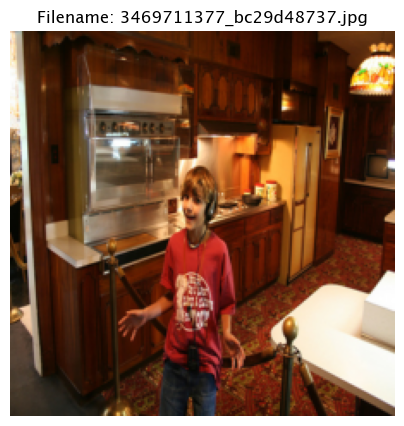

In [15]:
# Print an example prediction
file, image, caption = test_dataset[0]
output = model(image.unsqueeze(0), caption.unsqueeze(0))

# Prepare output
output = output.squeeze(0)

# reconstruct caption
print([word2vec.wv.most_similar([word.detach().numpy()], topn=1)[0][0] for word in output])

# get image
image = images_dict[file]

# show image
plt.figure(figsize=(5, 5))
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Filename: {file}")
plt.axis("off")
plt.show()

### Schritt 4: Präsentation / Bericht 
- Präsentation (~10m): Kurze Präsentation mit Diskussion der wichtigsten Ergebnisse. <br> 
- Q&A (~10min): Klärung von Verständnisfragen zum Paper und der Umsetzung. <br>
- Bericht in Form eines gut dokumentierten, übersichtlichen Jupyter Notebooks. 

Dieses soll schliesslich auch abgegeben werden und dem Fachexperten erlauben, die <br>
Schritte nachzuvollziehen (allenfalls auch das Training erneut laufen zu lassen). <br>

## Beurteilung 
Beurteilt wird auf Basis des abgegebenen Notebooks:  
- Vollständige und korrekte Umsetzung der vereinbarten Aufgabestellung. 
- Klare, gut-strukturierte Umsetzung.  
- Schlüssige Beschreibung und Interpretation der Ergebnisse. Gut gewählte und gut <br> kommentierten Plots und Tabellen. 
- Vernünftiger Umgang mit (Computing-)Ressourcen. 
- Verständliche Präsentation der Ergebnisse.

## Referenzen, Key Words 
- Word Embedding (z.B. word2vec, glove), um Wörter in numerische Vektoren in einem <br> geeignet dimensionierten Raum zu mappen. Siehe z.B. Andrew Ng, Coursera: <br>https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s  
- Bild Embedding mittels vortrainierten (evt. retrained) Netzwerken wie beispielsweise <br>ResNet, GoogLeNet, EfficientNet oder ähnlich. Transfer-Learning. 
- Seq2Seq Models bekannt für Sprach-Übersetzung.  